In [1]:
#necessary imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from tqdm import tqdm
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load Data including masks and images
phys_images = glob.glob("/content/drive/My Drive/archive-3/images/*.png")
phys_images.sort()
labels = glob.glob("/content/drive/My Drive/archive-3/masks/*.png")
labels.sort()
# load images and normalize
phys = []
for img in phys_images:
    n = cv2.imread(img)
    n = cv2.cvtColor(n, cv2.COLOR_BGR2RGB)
    n = cv2.resize(n, (256, 256), interpolation = cv2.INTER_AREA)
    n = n/255.0
    phys.append(n)
masks = []
for img in labels:
    n = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
    n= cv2.resize(n, (256,256), interpolation = cv2.INTER_AREA)
    masks.append(n)

In [ ]:
# Create x and y data
x_data= np.array(phys)
y_data = np.array(masks)
#print(y_train.shape)
y_data = np.eye(3)[y_data]


(292, 256, 256, 3) (292, 256, 256, 3)
(74, 256, 256, 3) (74, 256, 256, 3)


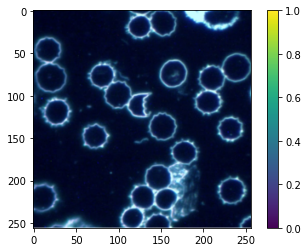

In [ ]:
x_train = x_data[range(0,292)]
y_train = y_data[range(0,292)]
x_val = x_data[range(292,len(x_data))]
y_val = y_data[range(292,len(y_data))]

# crop to size for training

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

#plot x_data to see if data loaded correctly
plt.imshow(x_train[0,:,:])
plt.colorbar()

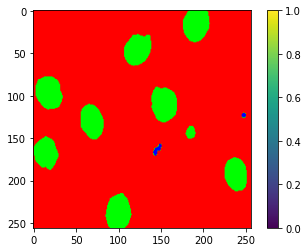

In [ ]:
#plot label data
plt.imshow(y_train[2,:,:])
plt.colorbar()

In [ ]:
# UNET Model
class UNet(tf.keras.models.Model):
  def __init__(self):
    super().__init__()

    self.conv1 = tf.keras.layers.Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch1 = tf.keras.layers.BatchNormalization()
    self.conv2 = tf.keras.layers.Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch2 = tf.keras.layers.BatchNormalization()
    self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))
    self.conv3 = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch3 = tf.keras.layers.BatchNormalization()
    self.conv4 = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch4 = tf.keras.layers.BatchNormalization()
    self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))
    self.conv5 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch5 = tf.keras.layers.BatchNormalization()
    self.conv6 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch6 = tf.keras.layers.BatchNormalization()
    self.pool3 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))
    self.conv7 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch7 = tf.keras.layers.BatchNormalization()
    self.conv8 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch8 = tf.keras.layers.BatchNormalization()
    self.pool4 = tf.keras.layers.MaxPooling2D(pool_size = (2,2))

    self.conv9 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch9 = tf.keras.layers.BatchNormalization()
    self.conv10 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch10 = tf.keras.layers.BatchNormalization()
    
    self.up1 = tf.keras.layers.UpSampling2D(size = (2,2))
    self.conv11 = tf.keras.layers.Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    #merge after this step
    self.conv12 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch11 = tf.keras.layers.BatchNormalization()
    self.conv13 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch12 = tf.keras.layers.BatchNormalization()
    self.up2 = tf.keras.layers.UpSampling2D(size = (2,2))
    self.conv14 = tf.keras.layers.Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    #merge after this step
    self.conv15 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch13 = tf.keras.layers.BatchNormalization()
    self.conv16 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch14 = tf.keras.layers.BatchNormalization()
    self.up3 = tf.keras.layers.UpSampling2D(size = (2,2))
    self.conv17 = tf.keras.layers.Conv2D(16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    #Merge after this step
    self.conv18 = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch15 = tf.keras.layers.BatchNormalization()
    self.conv19 = tf.keras.layers.Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch16 = tf.keras.layers.BatchNormalization()
    self.up4 = tf.keras.layers.UpSampling2D(size = (2,2))
    self.conv20 = tf.keras.layers.Conv2D(8, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    #Merge after this step
    self.conv21 = tf.keras.layers.Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch17 = tf.keras.layers.BatchNormalization()
    self.conv22 = tf.keras.layers.Conv2D(8, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')
    self.batch18 = tf.keras.layers.BatchNormalization()
    self.conv23 = tf.keras.layers.Conv2D(3, 1, activation = 'softmax', padding = 'same', kernel_initializer = 'he_normal')
  
  def call(self, input):  
    conv1 = self.conv1(input)
    conv1 = self.batch1(conv1)
    conv1 = self.conv2(conv1)
    conv1 = self.batch2(conv1)
    pool1 = self.pool1(conv1)

    conv2 = self.conv3(pool1)
    conv2 = self.batch3(conv2)
    conv2 = self.conv4(conv2)
    conv2 = self.batch4(conv2)
    pool2 = self.pool2(conv2)

    conv3 = self.conv5(pool2)
    conv3 = self.batch5(conv3)
    conv3 = self.conv6(conv3)
    conv3 = self.batch6(conv3)
    pool3 = self.pool3(conv3)

    conv4 = self.conv7(pool3)
    conv4 = self.batch7(conv4)
    conv4 = self.conv8(conv4)
    drop4 = self.batch8(conv4)
    pool4 = self.pool4(drop4)

    conv5 = self.conv9(pool4)
    conv5 = self.batch9(conv5)
    conv5 = self.conv10(conv5)
    drop5 = self.batch10(conv5)

    up6 = self.up1(drop5)
    up6 = self.conv11(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = self.conv12(merge6)
    conv6 = self.batch11(conv6)
    conv6 = self.conv13(conv6)
    conv6 = self.batch12(conv6)

    up7 = self.up2(conv6)
    up7 = self.conv14(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = self.conv15(merge7)
    conv7 = self.batch13(conv7)
    conv7 = self.conv16(conv7)
    conv7 = self.batch14(conv7)

    up8 = self.up3(conv7)
    up8 = self.conv17(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = self.conv18(merge8)
    conv8 = self.batch15(conv8)
    conv8 = self.conv19(conv8)
    conv8 = self.batch16(conv8)

    up9 = self.up4(conv8)
    up9 = self.conv20(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = self.conv21(merge9)
    conv9 = self.batch17(conv9)
    conv9 = self.conv22(conv9)
    conv9 = self.batch18(conv9)

    return self.conv23(conv9)

model = UNet()


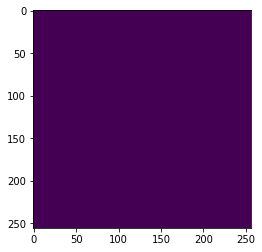

In [ ]:
phasemask = tf.Variable(initial_value = tf.ones([256,256], dtype = tf.float32), trainable = True, constraint=tf.keras.constraints.NonNeg(), name = 'phase_mask')
plt.imshow(phasemask.numpy())

In [ ]:
def physical_layer(x_batch,mask):

    x_batch=x_batch[:, :, :, 0] 
    
    output1= phasemask * tf.cast(x_batch, dtype = tf.float32)
    image = tf.math.abs(output1)**2

    #add noise
    noise_sig = .2
    noise = tf.random.normal(shape = tf.shape(image), mean = 0.0, stddev = noise_sig)
    image += noise
    image = image[..., tf.newaxis]
    
    
    return image-1
    

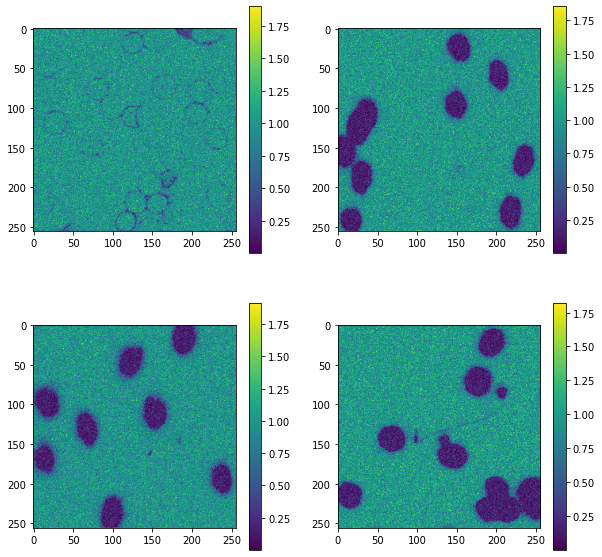

In [ ]:
def plot_examples(batch):
    plt.figure(figsize=(10, 10))
    for i in range(4):
        plt.subplot(2, 2, i+1)
        plt.imshow(abs(batch[i,:,:,0]))
        plt.colorbar()
        plt.axis('on')
    plt.show()

plot_examples(physical_layer(x_train[:4],phasemask).numpy())

In [ ]:
def forward_model(x_batch,mask):
    p_layer_out = physical_layer(x_batch, mask)
    return model(p_layer_out)


In [ ]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.optimizers.Adam(1e-3)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.CategoricalCrossentropy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.CategoricalCrossentropy(name='test_accuracy')

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)

In [ ]:
@tf.function 
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = forward_model(images, phasemask)
        loss = loss_object(labels, predictions)
        sources = model.trainable_variables
        sources.append(phasemask)
        
    gradients = tape.gradient(loss, sources)
    optimizer.apply_gradients(zip(gradients, sources))

    train_loss(loss)
    train_acc(labels, predictions)
def test_step(images, labels):
  predictions = forward_model(images,phasemask)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_acc(labels, predictions)

In [ ]:
loss_train = [] 
loss_val = []

In [ ]:
EPOCHS = 25
for epoch in range(EPOCHS):
  # Reset the metrics at the start of the next epoch
  train_loss.reset_states()
  train_acc.reset_states()
  test_loss.reset_states()
  test_acc.reset_states()

  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  print(
    f'Epoch {epoch + 1}, '
    f'Loss: {train_loss.result()}, '
    f'Test Loss: {test_loss.result()}, '
  )
  loss_train.append(train_acc.result())
  loss_val.append(test_acc.result())

Epoch 1, Loss: 1.0524377822875977, Test Loss: 1.0324931144714355, 
Epoch 2, Loss: 1.009120225906372, Test Loss: 0.9782998561859131, 
Epoch 3, Loss: 0.7192764282226562, Test Loss: 0.6549428105354309, 
Epoch 4, Loss: 0.5167394876480103, Test Loss: 0.5154343247413635, 
Epoch 5, Loss: 0.48494309186935425, Test Loss: 0.4960068166255951, 
Epoch 6, Loss: 0.43497005105018616, Test Loss: 0.4788193702697754, 
Epoch 7, Loss: 0.41470152139663696, Test Loss: 0.4699367582798004, 
Epoch 8, Loss: 0.4171639382839203, Test Loss: 0.4855403006076813, 
Epoch 9, Loss: 0.3966667652130127, Test Loss: 0.4503191411495209, 
Epoch 10, Loss: 0.3665805160999298, Test Loss: 0.43265318870544434, 
Epoch 11, Loss: 0.36138057708740234, Test Loss: 0.4323767423629761, 
Epoch 12, Loss: 0.3539153039455414, Test Loss: 0.41707655787467957, 
Epoch 13, Loss: 0.3428187370300293, Test Loss: 0.43755897879600525, 
Epoch 14, Loss: 0.35176581144332886, Test Loss: 0.40021705627441406, 
Epoch 15, Loss: 0.3439313471317291, Test Loss: 0.

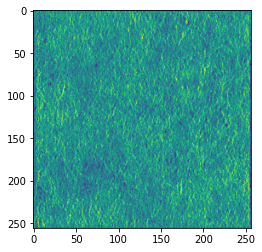

In [ ]:
plt.imshow(phasemask.numpy())

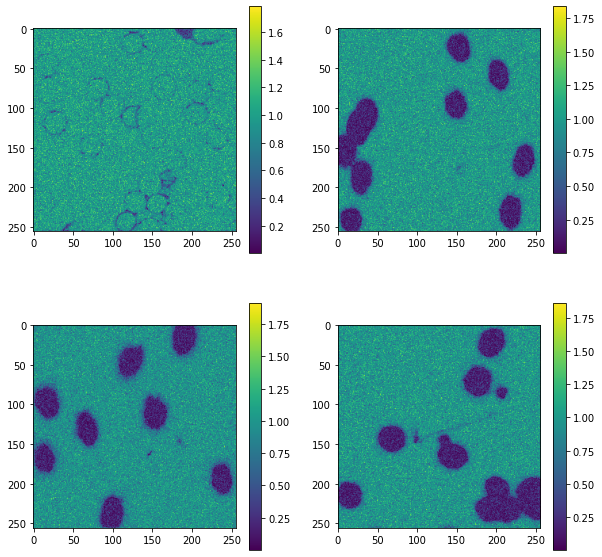

In [ ]:
plot_examples(physical_layer(x_train[:4],phasemask).numpy())

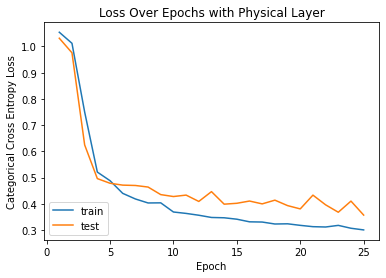

In [ ]:
epoch = np.linspace(1, 25)

plt.plot(epoch,loss_train)
plt.plot(epoch,loss_test)
plt.title("Loss Over Epochs with Physical Layer")
plt.ylabel("Categorical Cross Entropy Loss")
plt.xlabel("Epoch")
plt.legend(["train", "test"], loc="lower left")
plt.show()
